In [25]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt
import datetime as dt
import seaborn as sb
import pmdarima as pm
sb.set()

from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from itertools import product
from tqdm import tqdm_notebook
from arch import arch_model

import warnings
warnings.filterwarnings('ignore')

In [26]:
train = pd.read_csv("../../Data/AAPLTrain.csv",parse_dates=['Date'],index_col=['Date'])
test = pd.read_csv("../../Data/AAPLTest.csv",parse_dates=['Date'],index_col=['Date'])

In [27]:
train = train.loc[lambda x : x.index > dt.datetime(2012,12,31)]
df = pd.concat([train,test])

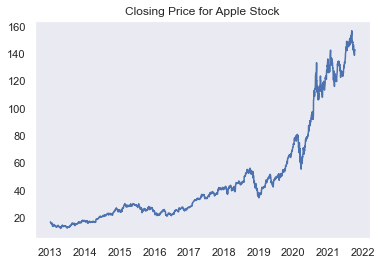

In [28]:
plt.plot(df.index,df['Adj Close'])
plt.title("Closing Price for Apple Stock")
plt.grid(False)
plt.show()

In [29]:
def plot_moving_average(series,window,plot_intervals=False,scale=1.96):
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(17,8))
    plt.title('Moving Average \n Window size = {}'.format(window))
    plt.plot(rolling_mean,'g',label="Rolling Mean trend")

    if plot_intervals:
        mae = mean_absolute_error(series[window:],rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--',label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

        plt.plot(series[window:],label='Actual values')
        plt.legend(loc='best')
        plt.grid(True)

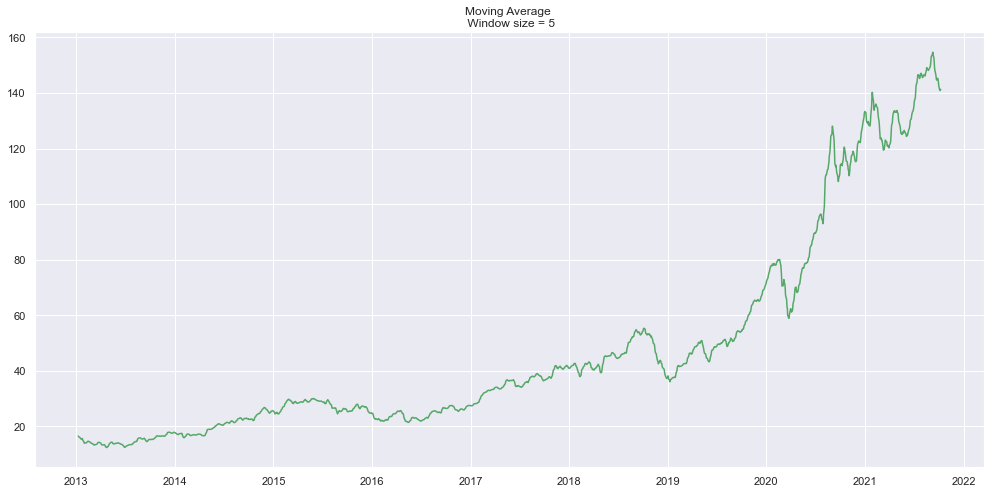

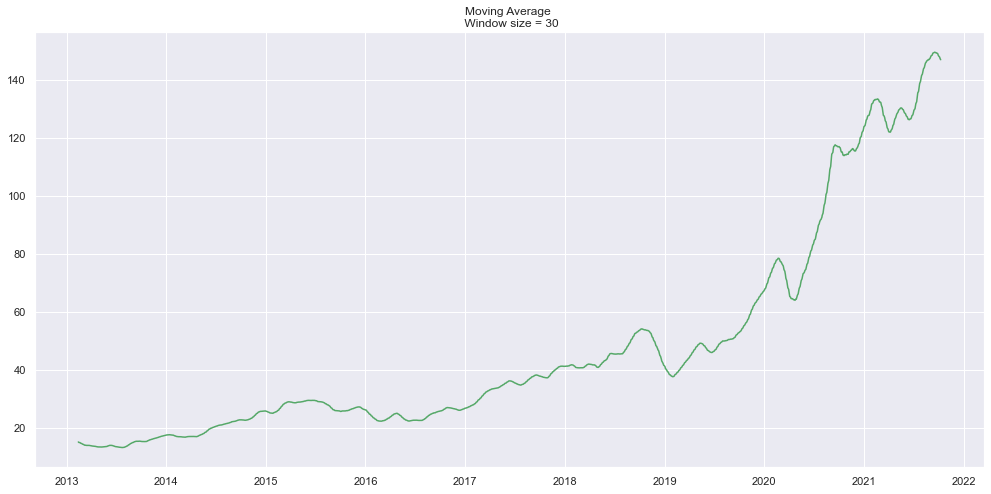

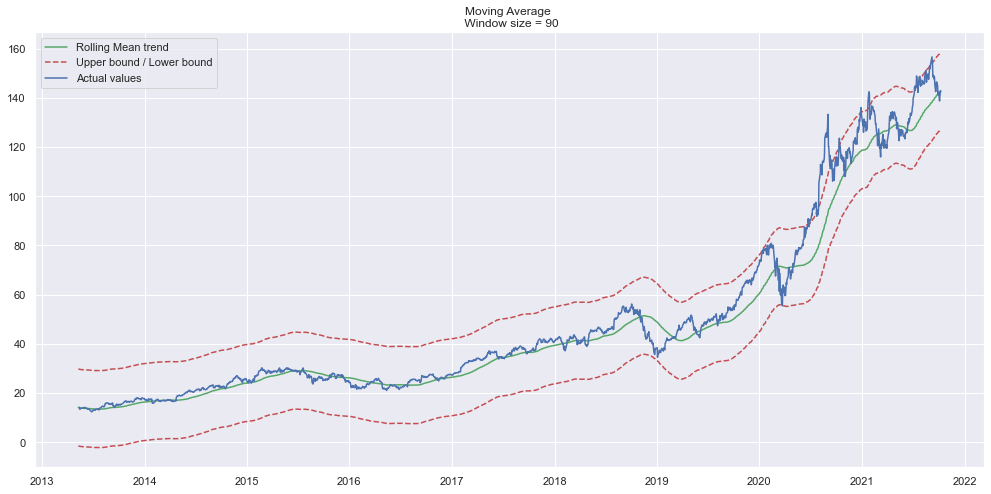

In [30]:
plot_moving_average(df['Adj Close'],5)

plot_moving_average(df['Adj Close'],30)

plot_moving_average(df['Adj Close'],90,plot_intervals=True)

In [31]:
def tsplot(y, lags=None, figsize=(12,7), style='bmh'):

    if not isinstance(y,pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout,(1,0))
        pacf_ax = plt.subplot2grid(layout,(1,1))

        y.plot(ax=ts_ax)
        p_value = adfuller(y)[1]
        ts_ax.set_title('Time Series Anaysis Plot \n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y,lags=lags,ax=acf_ax)
        smt.graphics.plot_pacf(y,lags=lags,ax=pacf_ax)
        plt.tight_layout()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6947.494, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6968.941, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6947.690, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6948.718, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6972.134, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6949.417, Time=0.84 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6949.396, Time=1.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6949.461, Time=0.55 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6948.624, Time=0.26 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6950.703, Time=1.88 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6951.538, Time=0.26 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 5.797 seconds


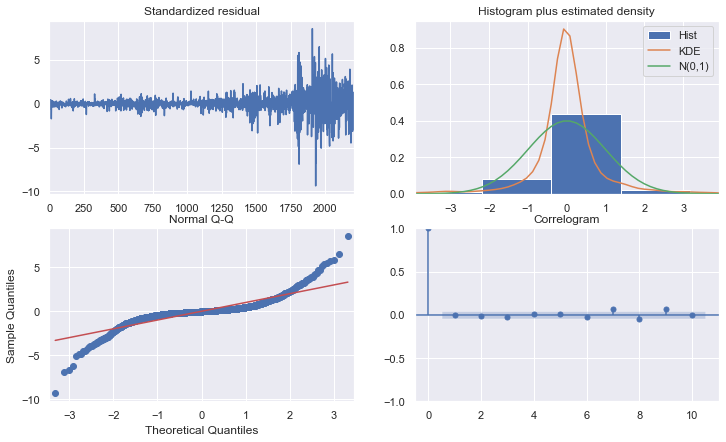

In [32]:
model = pm.auto_arima(df['Adj Close'],start_p=1,start_q=1,test='adf',start_P=1,start_Q=1,D=1,d=None,trace=True,error_action='ignore')
model.plot_diagnostics(figsize=(12,7))
plt.show()

In [33]:
ps = range(0,2)
d = 1
qs = range(0,2)
Ps = range(0,2)
D = 1
Qs = range(0,2)
s = 5

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

def optimize_ARIMA(parameters_list,d,D,s):
    results = []
    best_aic = float('inf')
    for param in tqdm_notebook(parameters_list):
        model = ARIMA(df['Adj Close'],order=(param[0],d,param[1]),seasonal_order=(param[2],D,param[3],s)).fit()

        aic = model.aic

        if aic < best_aic:
            best_aic = aic
        results.append([param, model.aic])

    result_table = pd.DataFrame(results, columns=['parameters','aic'])
    result_table = result_table.sort_values(by='aic',ascending=True).reset_index(drop=True)
    return result_table

In [34]:
result_table = optimize_ARIMA(parameters_list,d,D,s)
p,q,P,Q = result_table.parameters[0]
best_model = ARIMA(df['Adj Close'],order=(p,d,q),seasonal_order=(P,D,Q,s)).fit()
arima_pred = best_model.predict(start=test.index[0], end=test.index[-1])

  0%|          | 0/16 [00:00<?, ?it/s]

[]

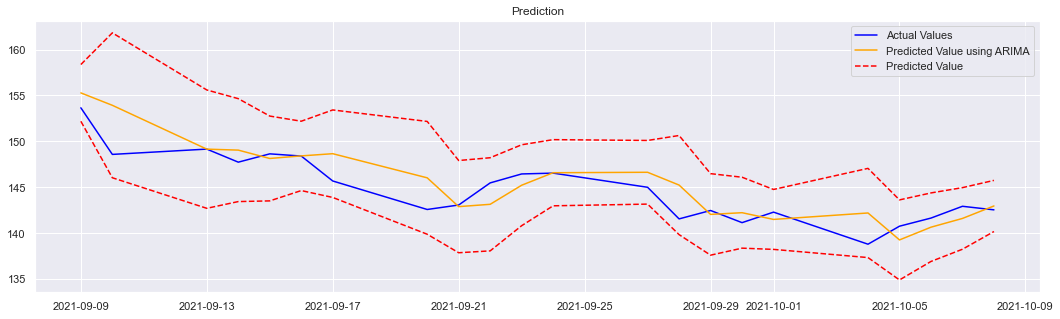

In [35]:
resid = best_model.resid.dropna()
model = arch_model(resid)
res = model.fit(disp='off',last_obs=test.index[1])
forecast = res.forecast()
pred_G = forecast.residual_variance['h.1'].dropna()
test['Upper'] = arima_pred.values + pred_G.values
test['Lower'] = arima_pred.values - pred_G.values
fig = plt.figure(figsize=(18,5))
plt.plot(test['Adj Close'], color="blue",label="Actual Values")
plt.plot(arima_pred, color="orange",label="Predicted Value using ARIMA")
plt.plot(test['Upper'],color="red",linestyle="--", label="Predicted Value")
plt.plot(test['Lower'],color="red",linestyle="--")
plt.title("Prediction")
plt.legend()
plt.plot()